# Agent based or Individual based stochastic models  

## model conceptualization

* This is a model for describing African Swine Fever transmission within a certain forest. 
* the probability of a susceptible Boar to get infected depends on the environmental bacterial load in the forest
* an infected Boar sheds bacteria in environment through various routes

We are developing a simpler version of the model.  
We will assume SIR transmission 

## importing packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import math as math
import random as random 
from scipy import stats as stats
import math as ma
import scipy.special as sp
import pandas as pd
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_context("notebook", font_scale=1.30, rc={"lines.linewidth": 0.8})
%matplotlib inline

## Lets understand stochasticity

* Stochastic processes are randomly determined processes.   
* They are random but still have some central tendency.

## Model Parameters

In [2]:
pi= ma.pi

##Transmission probabilities 
m = 0.7; ##Transition probability from I- to S
q = 0.02; ##Transition Probability from I- to I+
pIp = 0.5; ## Proportion of boars going from I- to I + and becoming I+ 
r1 = 0.2; ##Transition Probability I= to C=
r2 = 0.02; ## Transition Probability I+ to C+
s = 0.15; ##Transition Probability C+ to I+
tau = 0.0096; ##Transition probability C+ to C-
pc = 1; ##Transition Probability from C- to I+

mu = 0.2 ## DEATH OF BACTERIA IN ENVIRONMENT COMPARTMENT
pmf = 0.28; ##Probability of bacteria shed hrough muucs/ feces filing the environement compartment 

## Shedding level probabilities for Iminus 
qte1 = [0.85,0.15,0];
rho = 0.28; ##fraction of excreted bacteria in mucus / feces contaminating the environment
High = 1/float(30); ##qunatity of bacteria shed by high shedding animal durin one week
#High = 1
intitialBoarsize = 50; #Animals in the Forest

## Agent characteristics 

In [3]:
def enum(enumName, *listValueNames):
    # A sequence of integers, we create as 
    # As there are values in the enum.
    listValueNumbers = range(len(listValueNames))
    # Creation definately attributes. 
    # Fill with initial correspondence: enum value -> integer
    dictAttrib = dict( zip(listValueNames, listValueNumbers) )
    # Create the reverse dictionary. whole -> enum value
    dictReverse = dict( zip(listValueNumbers, listValueNames) )
    # Adding the inverse dictionary in attributes
    dictAttrib["dictReverse"] = dictReverse
    # Create and renvoyage type
    mainType = type(enumName, (), dictAttrib)
    return mainType
    
Health = enum("Health", "Susceptible", "Infected", "Recovered")
Forestinfectedornot = enum("Forestinfectedornot","InfectionFree", "Infected")
ForestExposedtoBacteria = enum("ForestExposedtoBacteria","NotExposed","Exposed")

## Agents

In [4]:
class Boar(object):
    def __init__(self, healthstate = Health.Susceptible):
        self.healthstate = healthstate
        
    def __repr__(self):
        return str(self.healthstate)
    
    def setHealthState(self, state):
        self.healthstate = state
    
    def changeSusceptible(self, Multinomial):
        if Multinomial[1] == 1:
            self.healthstate = Health.Infected
            return True
        return False
    
    def changeInfected(self, Multinomial):
        if Multinomial[0] == 1:
            self.setHealthState(Health.Susceptible)
            return True
        elif Multinomial[1] == 1:
            self.setHealthState(Health.Infected)
        elif Multinomial[2] ==1:
            self.setHealthState(Health.Recovered)
            return True
        return False

In [5]:
class calendar (object):
    def __init__(self, week=random.randint(1,52)):
        self.week = week
       
    def ChangeOneWeek (self):
        if self.week < 52:
            self.week = self.week+1;
        if self.week == 52:
            self.week = 0

In [6]:
# Description of Objects:  Forest

            
class Forest (object):
    def __init__(self, initialForestSize=None, time = None, ForestId = None):
        self.initialForestSize = initialForestSize
        self.time = time
        self.ForestID = ForestId
        self.A = 17*self.initialForestSize
        
        self.S = 0;
        self.I = 0;
        self.R = 0;
        self.E = 0;
        
        self.Slist = []
        self.Ilist = []
        self.clist = []
        self.Elist = []
        self.Elist.append(self.E)
        self.Nlist = []
        self.incidence = np.zeros(time_length)
        
        self.N = initialForestSize
        
        
        
        self.pinfection = 1-math.exp(-(self.E))
        
        self.Forestinfectionstate = False 
        
        
        self.PopulateForest()
        
    def PopulateForest(self):
        self.lBoars = [Boar(healthstate=Health.Susceptible) for i in range(self.initialForestSize)]
        
    def __repr__(self):
        return str(self.ForestID)
    def InitiateInfection(self,TimeStep):
        #self.lBoars[0].healthstate = Health.Infected;
        #self.lBoars[1].healthstate = Health.Infected;
        
        #self.Forestinfectionstate = True
        self.ForestExposedAir = ForestExposedtoBacteria.Exposed
        self.E = 0.01
#        self.indexcases = 4

    def InfectionDynamics (self, TimeStep):
        if self.pinfection<0:
            self.pinfection =0
        ## loop for all Boars
        for iBoar in self.lBoars:
            if iBoar.healthstate==Health.Susceptible: 
                state=np.random.multinomial(1, [(1-self.pinfection), self.pinfection])
                isInfected = iBoar.changeSusceptible(state)
                #if isInfected:
                #    print(iBoar.healthstate)


            elif iBoar.healthstate==Health.Infected:
                state=np.random.multinomial(1,[m,(1-m-q),q])
                becomingSusceptible = iBoar.changeInfected(state)
                    
        ## Live animals, will be counted each time step
        self.S=0;
        self.I=0;
        self.c=0;
        self.N=0; 
        
#____________Enumerating number of animals in each healthstate _______________________________________________________________________________________________________________________________________________________________
        
        for iBoar in (self.lBoars[:]):
            if iBoar.healthstate==Health.Susceptible:
                self.S+=1
            elif iBoar.healthstate==Health.Infected:
                self.I+=1
            elif iBoar.healthstate==Health.Recovered:
                self.c+=1
        self.N  =self.S+self.I +self.c
        #print(self.I)
        
        
    def BacteriaExcretion (self):
        E1=0;
        Q1Dl = 0;
        ## Calculating the bacteria shedd at time "t"
        for iBoar in self.lBoars:
            if iBoar.healthstate==Health.Infected:# I shedding with feces
                sheddinglevelprob=np.random.multinomial(1,qte1)
                if sheddinglevelprob[1]==1:
                    Q1Dl+=1 ## *low
        
#____________Counting the Bacteria shed accordint to the SEASON _______________________________________________________________________________________________________________________________________________________________        
        E1=Q1Dl*High*rho
        self.E+=(E1-(self.E*mu))
        #print(self.E)
        
    
    def calculationInfectionProbability (self):
        self.pinfection=1-math.exp(-(self.E))
        #print(self.pinfection)
        
    
    def appendingTimeLoopResults(self):
        self.Slist.append(self.S)
        self.Ilist.append(self.I)
        self.clist.append(self.c)
        self.Nlist.append(self.N)
        self.Elist.append(self.E)
        
        if self.Forestinfectionstate == True and self.I == 0:
            self.Forestinfectionstate == False
            

In [7]:
class ResultsInfectionCause (object):
    def __init__ (self,lForests):
        self.Prevalence=0
    def appendInfectionCauses (self, lForests):
        for iForest in lForests:
            #if iForest.Forestinfectionstate:
            if iForest.ExposedBy != infectionCause.Free :
                self.Prevalence+=1    
            
class Results (object):
    def __init__(self):
        self.Susc = []  ##Suscpetibles
        self.INFECTED= [] ##Iminus milk shedders
        self.CARRIERS = [] ##Carriers
        self.Eload=[] ## Environmental bacterial load
        
    def appendingSimuLoopResults (self, iForest):
        self.Susc.append(iForest.Slist)  ##Suscpetibles
        self.INFECTED.append(iForest.Ilist) 
        self.CARRIERS.append(iForest.clist) ##Carriers
        self.Eload.append(iForest.Elist) ## Environmental bacterial load
        
class SavingResultsInfectionCause (object):
    def __init__(self):
        self.ForestPrevalence=[]
    
    def appendingresultsofinfectioncause (self, ForestPrevalence):
        self.ForestPrevalence.append(ForestPrevalence)

class ForestInfectionProbability (object):
    def __init__ (self, simu):
        self.InfectedTimes= [0 for x in range(Forests)]
        self.ExposedByWIND= [0 for x in range(Forests)]
        self.ExposedByMOVEMENT= [0 for x in range(Forests)]
        self.MeanTimeforINFECTION=[[0 for x in range (simu)] for h in range(Forests)]
        
    def ForestInfectionProb (self,lForests,si):
        for iForest in lForests:
            if iForest.Forestinfectionstate== True:
                self.InfectedTimes[lForests.index (iForest)] +=1
            if iForest.ExposedBy == infectionCause.Wind :
                self.ExposedByWIND[lForests.index (iForest)] +=1
            if iForest.ExposedBy == infectionCause.Movement :
                self.ExposedByMOVEMENT[lForests.index (iForest) ]+=1
            if iForest.TimeforInfection!= None:
                self.MeanTimeforINFECTION[lForests.index (iForest)][si]= iForest.TimeforInfection

## Simulation

In [8]:
lResults = Results()


### Running simulation

In [9]:
%%time
### this command just print out the computer time required ro run this command

years=5; 
time_length=52*years;  ## number of time steps I am running the model
dt=1;  #time step
simu=100; #number of stochastic iteration

#### loop function that will run the model n times (n being the number of stochastic iterations)

for s in range(simu):
    ### generate a Forest
    iForest = Forest(
        initialForestSize=100,
        ForestId="UCDavis",
    )
    ## create Boars in our Forest
    iForest.PopulateForest()
    ##inisitate infection 
    iForest.InitiateInfection(TimeStep=1)
    
    ## Start the time loop
    for t in range (time_length):

        iForest.InfectionDynamics(TimeStep=t) ## first infection dynamics will play, Boars will change their health states
        iForest.BacteriaExcretion() ## then infected Boars will shed bacteria in the environment
        iForest.calculationInfectionProbability() ## estimate the probability of infection for a new Boar based on the contamination
        iForest.appendingTimeLoopResults() ## save results in for time t
        
    ## save results of one stochastic iteration in Results object
    lResults.appendingSimuLoopResults(iForest)

Wall time: 48.5 s


## Plotting results

In [10]:
## Convert all results to dataframe for easy plotting
Susceptibles = pd.DataFrame(lResults.Susc).T
Infected = pd.DataFrame(lResults.INFECTED).T
Recovered = pd.DataFrame(lResults.CARRIERS).T
Eload = pd.DataFrame(lResults.Eload).T

### Plot for health states

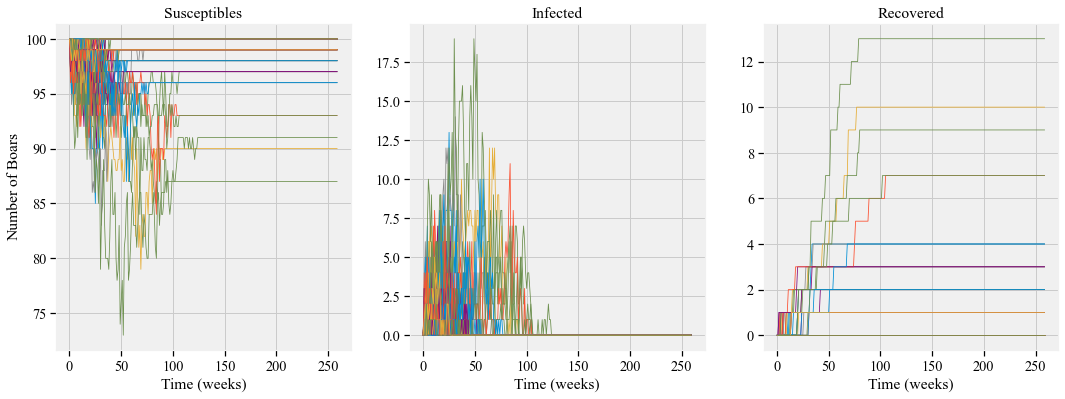

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = False, figsize  = [16,6])
#Susceptibles.plot(color = '#808080', ax = ax1)
#Infected.plot(color = '#808080', ax = ax2)
#Recovered.plot(color = '#808080', ax = ax3)
Susceptibles.plot( ax = ax1)
Infected.plot( ax = ax2)
Recovered.plot( ax = ax3)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax1.set_xlabel('Time (weeks)')
ax2.set_xlabel('Time (weeks)')
ax3.set_xlabel('Time (weeks)')
ax1.set_ylabel('Number of Boars')
ax1.set_title('Susceptibles')
ax2.set_title('Infected')
ax3.set_title('Recovered')

plt.show()

### plot for environmental contamination 

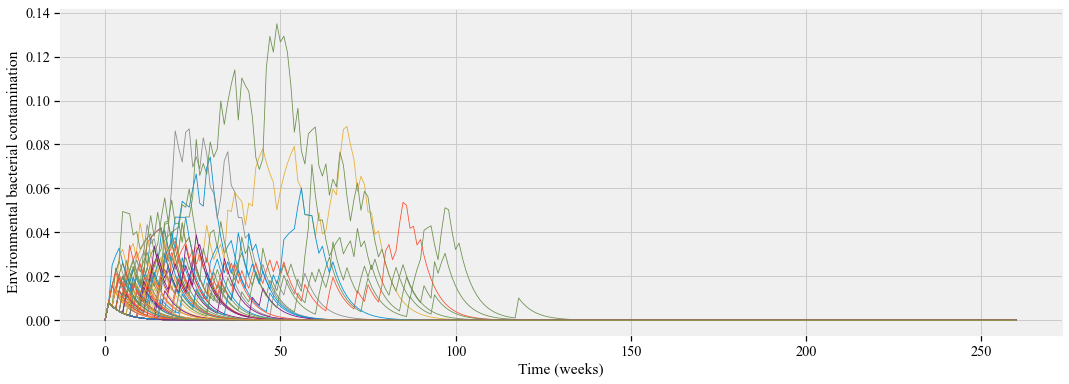

In [12]:
fig, (ax1) = plt.subplots(1, 1, sharey = True, figsize  = [16,6])
#Eload.plot(color = '#808080', ax = ax1)
Eload.plot(ax = ax1)
ax1.get_legend().remove()
ax1.set_xlabel('Time (weeks)')
ax1.set_ylabel('Environmental bacterial contamination')
plt.show()

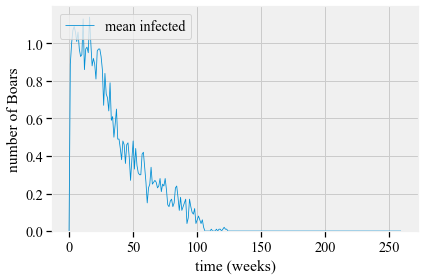

In [13]:
fig, ax = plt.subplots(figsize = (6,4))
Infected.mean(axis=1).plot(ax= ax,label='mean infected')
ax.set_ylim(0)
plt.legend(loc='upper left')
ax.set_ylabel('number of Boars')
ax.set_xlabel('time (weeks)')
plt.tight_layout()
plt.show()

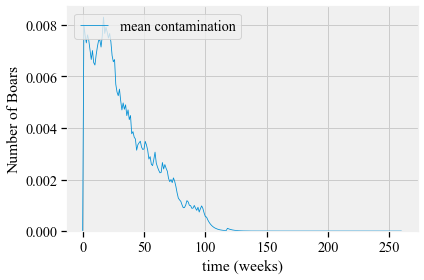

In [14]:
fig, ax = plt.subplots(figsize = (6,4))
Eload.mean(axis=1).plot(ax= ax,label='mean contamination')
ax.set_ylim(0)
plt.legend(loc='upper left')
ax.set_ylabel('Number of Boars')
ax.set_xlabel('time (weeks)')
plt.tight_layout()
plt.show()